In [27]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install paddlepaddle

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip uninstall numpy -y

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import paddle
from paddle import nn
from paddle.io import DataLoader, Dataset
import paddle.nn.functional as F
import pandas as pd
import numpy as np
import copy
import os
import math
import random
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.preprocessing import normalize
from tqdm import tqdm
from collections import defaultdict
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import faiss
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < LooseVersion("1.18")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p19

In [16]:
# 构建数据集
class SeqnenceDataset(Dataset):
    def __init__(self, config, df, phase='train'):
        self.config = config
        self.df = df
        self.max_length = self.config['max_length']
        self.df = self.df.sort_values(by=['user_id', 'timestamp'])
        self.user2item = self.df.groupby('user_id')['item_id'].apply(list).to_dict()
        self.user_list = self.df['user_id'].unique()
        self.phase = phase
    def __len__(self, ):
        return len(self.user2item)
    def __getitem__(self, index):
        if self.phase == 'train':
            user_id = self.user_list[index]
            item_list = self.user2item[user_id]
            hist_item_list = []
            hist_mask_list = []
            k = random.choice(range(4, len(item_list)))
            item_id = item_list[k] 
            if k >= self.max_length: 
                hist_item_list.append(item_list[k - self.max_length: k])
                hist_mask_list.append([1.0] * self.max_length)
            else:
                hist_item_list.append(item_list[:k] + [0] * (self.max_length - k))
                hist_mask_list.append([1.0] * k + [0.0] * (self.max_length - k))

            return paddle.to_tensor(hist_item_list).squeeze(0), paddle.to_tensor(hist_mask_list).squeeze(
                0), paddle.to_tensor([item_id])
        else:
            user_id = self.user_list[index]
            item_list = self.user2item[user_id]
            hist_item_list = []
            hist_mask_list = []
            k = int(0.8 * len(item_list))
            if k >= self.max_length: 
                hist_item_list.append(item_list[k - self.max_length: k])
                hist_mask_list.append([1.0] * self.max_length)
            else:
                hist_item_list.append(item_list[:k] + [0] * (self.max_length - k))
                hist_mask_list.append([1.0] * k + [0.0] * (self.max_length - k))
            return paddle.to_tensor(hist_item_list).squeeze(0), paddle.to_tensor(hist_mask_list).squeeze(
                0), item_list[k:]

    def get_test_gd(self):
        self.test_gd = {}
        for user in self.user2item:
            item_list = self.user2item[user]
            test_item_index = int(0.8 * len(item_list))
            self.test_gd[user] = item_list[test_item_index:]
        return self.test_gd

In [17]:
# 基础序列召回模型
class GRU4Rec(nn.Layer):
    def __init__(self, config):
        super(GRU4Rec, self).__init__()
        self.config = config
        self.embedding_dim = self.config['embedding_dim']
        self.max_length = self.config['max_length']
        self.n_items = self.config['n_items']
        self.num_layers = self.config['num_layers']
        self.item_emb = nn.Embedding(self.n_items, self.embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            input_size=self.embedding_dim,
            hidden_size=self.embedding_dim,
            num_layers=self.num_layers,
            time_major=False,
        )
        self.loss_fun = nn.CrossEntropyLoss()
        self.reset_parameters()
    def calculate_loss(self,user_emb,pos_item):
        all_items = self.item_emb.weight
        scores = paddle.matmul(user_emb, all_items.transpose([1, 0]))
        return self.loss_fun(scores,pos_item)
    
    def output_items(self):
        return self.item_emb.weight
    
    def reset_parameters(self, initializer=None):
        for weight in self.parameters():
            paddle.nn.initializer.KaimingNormal(weight)
            
    def forward(self, item_seq, mask, item, train=True):
        seq_emb = self.item_emb(item_seq)
        seq_emb,_ = self.gru(seq_emb)
        user_emb = seq_emb[:,-1,:] 
        if train:
            loss = self.calculate_loss(user_emb,item)
            output_dict = {
                'user_emb':user_emb,
                'loss':loss
            }
        else:
            output_dict = {
                'user_emb':user_emb
            }
        return output_dict

In [18]:
# pipeline
config = {
    'train_path':'/Users/yxy/PycharmProjects/序列召回data/train_enc.csv',
    'valid_path':'/Users/yxy/PycharmProjects/序列召回data/valid_enc.csv',
    'test_path':'/Users/yxy/PycharmProjects/序列召回data/test_enc.csv',
    'lr':1e-4,
    'Epoch':100,
    'batch_size':256,
    'embedding_dim':16,
    'num_layers':1,
    'max_length':20,
    'n_items':15406,
    'K':4
}

In [19]:
def my_collate(batch):
    hist_item, hist_mask, item_list = list(zip(*batch))

    hist_item = [x.unsqueeze(0) for x in hist_item]
    hist_mask = [x.unsqueeze(0) for x in hist_mask]

    hist_item = paddle.concat(hist_item,axis=0)
    hist_mask = paddle.concat(hist_mask,axis=0)
    return hist_item,hist_mask,item_list

In [20]:
def save_model(model, path):
    if not os.path.exists(path):
        os.makedirs(path)
    paddle.save(model.state_dict(), path + 'model.pdparams')
def load_model(model, path):
    state_dict = paddle.load(path + 'model.pdparams')
    model.set_state_dict(state_dict)
    print('model loaded from %s' % path)
    return model

In [21]:
# 基于faiss的向量召回
def get_predict(model, test_data, hidden_size, topN=20):
    item_embs = model.output_items().cpu().detach().numpy()
    item_embs = normalize(item_embs, norm='l2')
    gpu_index = faiss.IndexFlatIP(hidden_size)
    gpu_index.add(item_embs)    
    test_gd = dict()
    preds = dict() 
    user_id = 0

    for (item_seq, mask, targets) in tqdm(test_data): # 获取用户嵌入
        user_embs = model(item_seq,mask,None,train=False)['user_emb']
        user_embs = user_embs.cpu().detach().numpy()
# 使用内积作为指标，内积越大越相似
# 多兴趣模型，shape=(batch_size, num_interest, embedding_dim)
# 其他模型，shape=(batch_size, embedding_dim)
    if len(user_embs.shape) == 2: # 非多兴趣模型
            user_embs = normalize(user_embs, norm='l2').astype('float32')
            D, I = gpu_index.search(user_embs, topN)
            for i, iid_list in enumerate(targets): 
                test_gd[user_id] = iid_list
                preds[user_id] = I[i,:]
                user_id +=1
    else:  # 多兴趣模型
            ni = user_embs.shape[1] 
            user_embs = np.reshape(user_embs,
                                   [-1, user_embs.shape[-1]])  
            user_embs = normalize(user_embs, norm='l2').astype('float32')
            D, I = gpu_index.search(user_embs, topN)  
            for i, iid_list in enumerate(targets):  
                recall = 0
                dcg = 0.0
                item_list_set = []
                item_list = list(
                    zip(np.reshape(I[i * ni:(i + 1) * ni], -1), np.reshape(D[i * ni:(i + 1) * ni], -1)))
                item_list.sort(key=lambda x: x[1], reverse=True)  
                for j in range(len(item_list)): 
                    if item_list[j][0] not in item_list_set and item_list[j][0] != 0:
                        item_list_set.append(item_list[j][0])
                        if len(item_list_set) >= topN:
                            break
                test_gd[user_id] = iid_list
                preds[user_id] = item_list_set
                user_id +=1
    return test_gd, preds

In [22]:
def evaluate(preds,test_gd, topN=50):
    total_recall = 0.0
    total_ndcg = 0.0
    total_hitrate = 0
    for user in test_gd.keys():
        recall = 0
        dcg = 0.0
        item_list = test_gd[user]
        for no, item_id in enumerate(item_list):
            if item_id in preds[user][:topN]:
                recall += 1
                dcg += 1.0 / math.log(no+2, 2)
            idcg = 0.0
            for no in range(recall):
                idcg += 1.0 / math.log(no+2, 2)
        total_recall += recall * 1.0 / len(item_list)
        if recall > 0:
            total_ndcg += dcg / idcg
            total_hitrate += 1
    total = len(test_gd)
    recall = total_recall / total
    ndcg = total_ndcg / total
    hitrate = total_hitrate * 1.0 / total
    return {f'recall@{topN}': recall, f'ndcg@{topN}': ndcg, f'hitrate@{topN}': hitrate}
def evaluate_model(model, test_loader, embedding_dim,topN=20):
    test_gd, preds = get_predict(model, test_loader, embedding_dim, topN=topN)
    return evaluate(preds, test_gd, topN=topN)

In [23]:
# 读取数据
train_df = pd.read_csv(config['train_path'])
valid_df = pd.read_csv(config['valid_path'])
test_df = pd.read_csv(config['test_path'])
train_dataset = SeqnenceDataset(config, train_df, phase='train')
valid_dataset = SeqnenceDataset(config, valid_df, phase='test')
test_dataset = SeqnenceDataset(config, test_df, phase='test')
train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True,num_workers=8)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'], shuffle=False,collate_fn=my_collate)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=False,collate_fn=my_collate)

In [30]:
model = GRU4Rec(config)
optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=config['lr'])
log_df = pd.DataFrame()
best_recall = -1
exp_path = './exp/ml-20m_softmax/MIND_{}_{}_{}/'.format(config['lr'],config['batch_size'],config['embedding_dim'])
os.makedirs(exp_path,exist_ok=True,mode=0o777)
patience = 5
last_improve_epoch = 1
log_csv = exp_path+'log.csv'

In [36]:
# 训练
for epoch in range(1, 1 + config['Epoch']):
    pbar = tqdm(train_loader)
    model.train()
    loss_list = []
    acc_50_list = []
    print()
    print('training:')
    print()
    for batch_data in pbar:
        (item_seq, mask, item) = batch_data
        output_dict = model(item_seq, mask, item)
        loss = output_dict['loss']
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        
        loss_list.append(loss.item())
        pbar.set_description('Epoch [{}/{}]'.format(epoch,config['Epoch']))
        pbar.set_postfix(loss = np.mean(loss_list))
        # 验证
    print('Valid')
    recall_metric = evaluate_model(model, valid_loader, config['embedding_dim'], topN=50)
    print(recall_metric)
    recall_metric['phase'] = 'valid'
    log_df = log_df.append(recall_metric, ignore_index=True)
    log_df.to_csv(log_csv)

    if recall_metric['recall@50'] > best_recall:
        save_model(model,exp_path)
        best_recall = recall_metric['recall@50']
        last_improve_epoch = epoch

    if epoch - last_improve_epoch > patience:
        break

print('Testing')
model = load_model(model, exp_path)
recall_metric = evaluate_model(model, test_loader, config['embedding_dim'], topN=50)
print(recall_metric)
recall_metric['phase'] = 'test'
log_df = log_df.append(recall_metric, ignore_index=True)
log_df.to_csv(log_csv)

Epoch [1/100]:   0%|                 | 2/431 [00:00<00:22, 18.91it/s, loss=6.99]


training:



Epoch [1/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.13it/s, loss=6.96]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.02it/s]


{'recall@50': 0.11139785565343806, 'ndcg@50': 0.3019419176714169, 'hitrate@50': 0.5591397849462365}


Epoch [2/100]:   1%|▏                   | 3/431 [00:00<00:14, 29.45it/s, loss=7]


training:



Epoch [2/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.66it/s, loss=6.96]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 95.05it/s]


{'recall@50': 0.10662168764875508, 'ndcg@50': 0.302885713200126, 'hitrate@50': 0.5698924731182796}


Epoch [3/100]:   1%|▏                | 4/431 [00:00<00:13, 31.31it/s, loss=6.97]


training:



Epoch [3/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.04it/s, loss=6.96]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 95.00it/s]


{'recall@50': 0.11225716374791661, 'ndcg@50': 0.31262614728067406, 'hitrate@50': 0.5752688172043011}


Epoch [4/100]:   1%|                 | 3/431 [00:00<00:14, 28.56it/s, loss=6.89]


training:



Epoch [4/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.12it/s, loss=6.96]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.67it/s]


{'recall@50': 0.11257907942500081, 'ndcg@50': 0.3045009303473332, 'hitrate@50': 0.5698924731182796}


Epoch [5/100]:   1%|                 | 3/431 [00:00<00:14, 29.98it/s, loss=6.96]


training:



Epoch [5/100]: 100%|███████████████| 431/431 [00:11<00:00, 36.98it/s, loss=6.96]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.77it/s]


{'recall@50': 0.11079256486099175, 'ndcg@50': 0.3072709741451434, 'hitrate@50': 0.5698924731182796}


Epoch [6/100]:   1%|                 | 3/431 [00:00<00:14, 29.49it/s, loss=6.96]


training:



Epoch [6/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.56it/s, loss=6.95]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.83it/s]


{'recall@50': 0.11593127701519625, 'ndcg@50': 0.31284499598454407, 'hitrate@50': 0.5752688172043011}


Epoch [7/100]:   1%|▏                | 4/431 [00:00<00:12, 33.05it/s, loss=6.99]


training:



Epoch [7/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.91it/s, loss=6.95]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.61it/s]


{'recall@50': 0.11319713490095346, 'ndcg@50': 0.30351181317927156, 'hitrate@50': 0.5698924731182796}


Epoch [8/100]:   1%|                 | 3/431 [00:00<00:14, 29.05it/s, loss=6.91]


training:



Epoch [8/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.71it/s, loss=6.95]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.65it/s]


{'recall@50': 0.11288438156206312, 'ndcg@50': 0.30293386835045416, 'hitrate@50': 0.5698924731182796}


Epoch [9/100]:   1%|▏                | 4/431 [00:00<00:12, 33.45it/s, loss=6.97]


training:



Epoch [9/100]: 100%|███████████████| 431/431 [00:11<00:00, 37.89it/s, loss=6.94]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.35it/s]


{'recall@50': 0.11205778133002667, 'ndcg@50': 0.2985495193966641, 'hitrate@50': 0.5698924731182796}


Epoch [10/100]:   1%|                | 3/431 [00:00<00:14, 28.55it/s, loss=6.91]


training:



Epoch [10/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.54it/s, loss=6.94]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.32it/s]


{'recall@50': 0.11666754562613657, 'ndcg@50': 0.3050770224118572, 'hitrate@50': 0.5698924731182796}


Epoch [11/100]:   1%|                | 3/431 [00:00<00:14, 29.79it/s, loss=6.92]


training:



Epoch [11/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.65it/s, loss=6.94]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 95.85it/s]


{'recall@50': 0.11469304623383947, 'ndcg@50': 0.3065544726319968, 'hitrate@50': 0.5645161290322581}


Epoch [12/100]:   1%|▏               | 4/431 [00:00<00:12, 32.93it/s, loss=6.99]


training:



Epoch [12/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.95it/s, loss=6.94]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.78it/s]


{'recall@50': 0.12176254970085425, 'ndcg@50': 0.3144283253608912, 'hitrate@50': 0.5752688172043011}


Epoch [13/100]:   1%|▏               | 4/431 [00:00<00:13, 32.18it/s, loss=6.95]


training:



Epoch [13/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.64it/s, loss=6.94]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.75it/s]


{'recall@50': 0.12490881790255597, 'ndcg@50': 0.31959823354271605, 'hitrate@50': 0.5806451612903226}


Epoch [14/100]:   1%|▏               | 4/431 [00:00<00:13, 31.74it/s, loss=6.99]


training:



Epoch [14/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.99it/s, loss=6.93]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.67it/s]


{'recall@50': 0.12480677119165645, 'ndcg@50': 0.322201444468081, 'hitrate@50': 0.5806451612903226}


Epoch [15/100]:   1%|                | 3/431 [00:00<00:14, 29.80it/s, loss=6.92]


training:



Epoch [15/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.90it/s, loss=6.93]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.64it/s]


{'recall@50': 0.12580451836395679, 'ndcg@50': 0.3137300848000095, 'hitrate@50': 0.5698924731182796}


Epoch [16/100]:   1%|                | 3/431 [00:00<00:15, 28.17it/s, loss=6.93]


training:



Epoch [16/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.95it/s, loss=6.92]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.36it/s]


{'recall@50': 0.11748942619805815, 'ndcg@50': 0.30757363049044645, 'hitrate@50': 0.5645161290322581}


Epoch [17/100]:   1%|▏               | 4/431 [00:00<00:13, 31.75it/s, loss=6.92]


training:



Epoch [17/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.84it/s, loss=6.93]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 94.23it/s]


{'recall@50': 0.12095260009543737, 'ndcg@50': 0.3227360927439191, 'hitrate@50': 0.5806451612903226}


Epoch [18/100]:   1%|▏               | 4/431 [00:00<00:13, 32.31it/s, loss=7.02]


training:



Epoch [18/100]: 100%|██████████████| 431/431 [00:11<00:00, 38.05it/s, loss=6.93]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 95.52it/s]


{'recall@50': 0.12120648539627982, 'ndcg@50': 0.32310131897990424, 'hitrate@50': 0.5806451612903226}


Epoch [19/100]:   1%|                | 3/431 [00:00<00:14, 28.77it/s, loss=6.93]


training:



Epoch [19/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.96it/s, loss=6.92]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 93.95it/s]


{'recall@50': 0.12201764883616985, 'ndcg@50': 0.32140123742998344, 'hitrate@50': 0.5860215053763441}


Epoch [20/100]:   1%|▏               | 4/431 [00:00<00:13, 32.64it/s, loss=6.93]


training:



Epoch [20/100]: 100%|██████████████| 431/431 [00:11<00:00, 37.17it/s, loss=6.92]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 93.08it/s]


{'recall@50': 0.12039510696794138, 'ndcg@50': 0.31734084082316877, 'hitrate@50': 0.5752688172043011}


Epoch [21/100]:   1%|▏               | 4/431 [00:00<00:12, 33.64it/s, loss=6.97]


training:



Epoch [21/100]: 100%|██████████████| 431/431 [00:11<00:00, 36.81it/s, loss=6.91]


Valid


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 92.73it/s]


{'recall@50': 0.12332641145305022, 'ndcg@50': 0.3287752965732281, 'hitrate@50': 0.5806451612903226}
Testing
model loaded from ./exp/ml-20m_softmax/MIND_0.0001_256_16/


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 91.77it/s]

{'recall@50': 0.08263692904317906, 'ndcg@50': 0.24522956251876063, 'hitrate@50': 0.53125}


In [37]:
log_df

,hitrate@50,ndcg@50,phase,recall@50
0,0.548387,0.290656,valid,0.103910
1,0.569892,0.304996,valid,0.110708
2,0.559140,0.301942,valid,0.111398
3,0.569892,0.302886,valid,0.106622
4,0.575269,0.312626,valid,0.112257
5,0.569892,0.304501,valid,0.112579
6,0.569892,0.307271,valid,0.110793
7,0.575269,0.312845,valid,0.115931
8,0.569892,0.303512,valid,0.113197
9,0.569892,0.302934,valid,0.112884


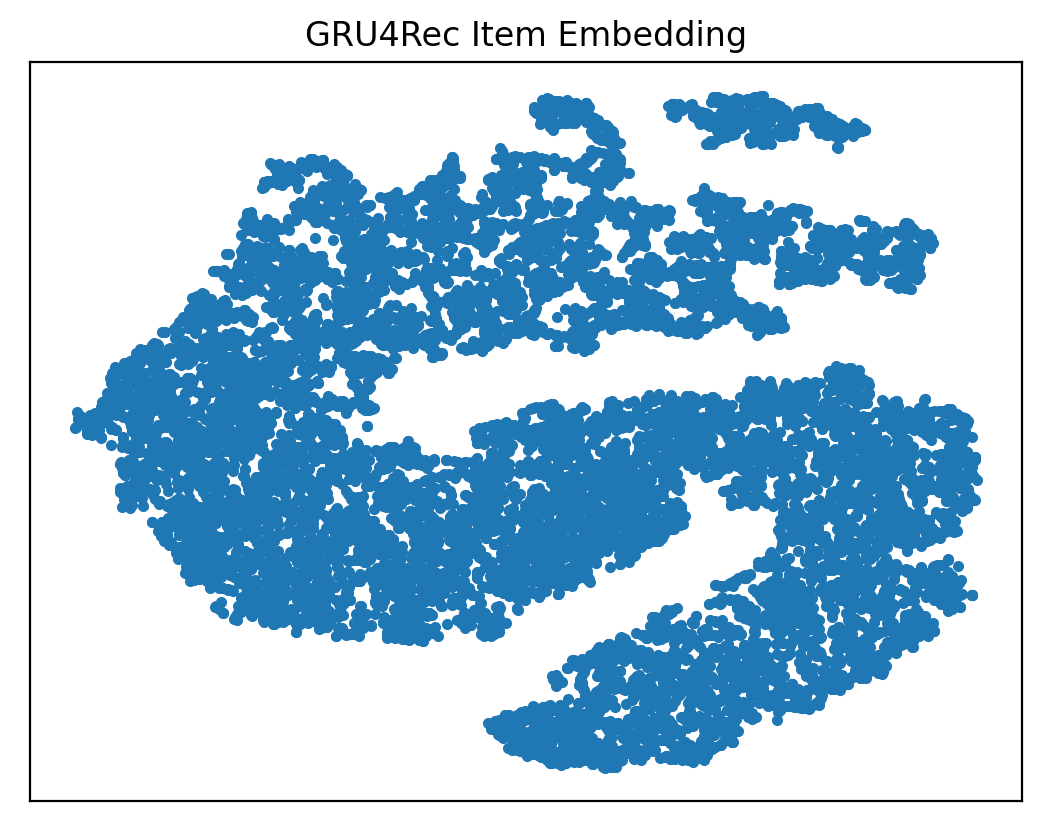

In [38]:
# 基于TSNE的Item Embedding分布可视化
def plot_embedding(data, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure(dpi=200)
    plt.scatter(data[:,0], data[:,1], marker='.')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
item_emb = model.output_items().numpy()
tsne_emb = TSNE(n_components=2).fit_transform(item_emb)
plot_embedding(tsne_emb,'GRU4Rec Item Embedding')